# Project: Clustering Enron emails
This project attempted to group similar enron emails using Kmeans clustering with Word2vec. For this I downloaded the emails from https://www.cs.cmu.edu/~enron/from and used the subject field.

In [2]:
import numpy as np
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import nltk
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans
import dash
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output
from dash import dash_table
import dash_html_components as html

In [3]:
#load data
df2 = pd.read_csv(r'C:\Users\tadhg\OneDrive\Python\Enron Email classification\Enron_meentings_bunch1.csv')
#clean text and save as list
clean_body = []
for i in df2['Subject']:
    #replace \n with a space
    temp = str(i).replace('\n',' ')
    #remove numbers
    digits = '[0-9]'
    temp = re.sub(digits, ' ', temp)
    #remo special characters
    temp = re.sub(r"[^a-zA-Z0-9]+", ' ', temp)
    clean_body.append(temp)
try:
    clean_body.remove(' ')   
except:
    pass

In [4]:
#create list of tokenized sentences
body_sentence = list()
i = 0
while i < len(clean_body):
    temp = word_tokenize(clean_body[i])
    body_sentence.append(temp)
    i += 1   

In [5]:
#create Word Vector Model
m = Word2Vec(body_sentence, size =100, min_count=1,sg=1)
def vectorizer(sent,m):
    vec=[]
    numw=0
    for w in sent:
        try:
            if numw ==0:
                vec = m[w]
            else: 
                vec = np.add(vec, m[w])
            numw+=1
        except:
            pass
        return np.asarray(vec) / numw

In [6]:
# Apply vectorizer function to return sentences as vectors
l =[]
for i in body_sentence:
    l.append(vectorizer(i,m))
x=np.array(l)

c:\devtools\python\python37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


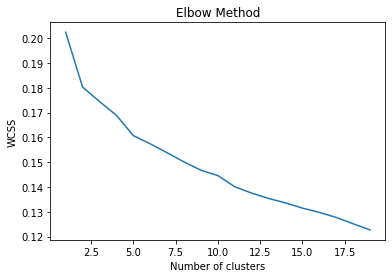

In [7]:
# Use the elbow method to determine number of clusters
wcss =[]
for i in range(1,20):
    kmeans = KMeans(n_clusters = i, init = 'k-means++',random_state=42)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,20),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [8]:
#determine the number of clusters 
n_clusters = 8
clf = KMeans(n_clusters = n_clusters,
             max_iter=100,
             init='k-means++',
             n_init=1)
labels = clf.fit_predict(x)

In [9]:
#Assign the labels to the subject and export the output
body_df = pd.DataFrame(clean_body,columns=['Subject'])
labes_df = pd.DataFrame(labels, columns =['Clusters'])
clusters = body_df.join(labes_df)
clusters.to_csv(r'C:\Users\tadhg\OneDrive\Python\Enron Email classification\clusters_Subject.csv')

In [10]:
# table with Cluster filters to explore the results:
app = JupyterDash(__name__)

app.layout = dash_table.DataTable(
    columns=[
        {'name': 'Subject', 'id': 'Subject', 'type': 'text'},
        {'name': 'Clusters', 'id': 'Clusters', 'type': 'numeric'},
    ],
    data=clusters.to_dict('records'),
    filter_action='native',

    style_table={
        'height': 200,
    },
    style_data={
        'width': '75px', 'minWidth': '75px', 'maxWidth': '75px',
        'overflow': 'hidden',
        'textOverflow': 'ellipsis',
    }
)
app.run_server(mode='inline')